**Table of contents**<a id='toc0_'></a>    
- [Setting up data and imports](#toc1_1_1_1_1_)    
      - [Optimization Setup](#toc1_1_1_2_)    
      - [SpOPT](#toc1_1_1_3_)    
      - [PyMOO Testing](#toc1_1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

##### <a id='toc1_1_1_1_1_'></a>[Setting up data and imports](#toc0_)

In [6]:
import pulp
from spopt.locate import PMedian

import geopandas as gpd
import pandas as pd

from importlib import reload

# Importing my modules
from src.main import data_loading, plotting, geometry_operations, optimization_functions, geometry_utilities, classes, cable_road_computation, mechanical_computations

In [8]:
# %store -r line_gdf_reworked
%store -r line_gdf_75
%store -r harvesteable_trees_gdf
%store -r height_gdf
%store -r anchor_trees_gdf
%store -r target_trees_gdf

line_gdf = line_gdf_75.copy()
# hack to extract this from the line_gdf
start_point_dict = dict(
    [(key, value.coords[0]) for key, value in enumerate(line_gdf["line_candidates"])]
)

#### <a id='toc1_1_1_2_'></a>[Optimization Setup](#toc0_)

In [23]:
reload(geometry_operations)
reload(optimization_functions)

# Apply the Line Cost Function:
line_gdf["line_cost"] = optimization_functions.compute_line_costs(line_gdf, uphill_yarding = True, large_yarder = False)

# Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
distance_tree_line, distance_carriage_support = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.reset_index()
demand_points_gdf = harvesteable_trees_gdf.reset_index()

# set up the solver
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "model"

# create the nr of possible facilities and clients 
client_range = range(distance_tree_line.shape[0])
facility_range = range(distance_tree_line.shape[1])

# add facility cost with an optional scaling factor
facility_scaling_factor = 0.1

facility_cost = line_gdf.line_cost.values*facility_scaling_factor

# create the aij cost matrix, which is really just the distance from the tree to the line
aij = distance_tree_line

# collect the matrices needed for the optimization
tree_volumes_list = harvesteable_trees_gdf["crownVolume"]
angle_between_supports_list = line_gdf["angle_between_supports"]
# cost_distance_tree_line
# distance_carriage_support

average_steepness = geometry_operations.compute_average_terrain_steepness(line_gdf, height_gdf)

# and the productivity cost combination of each line combination
productivity_cost = optimization_functions.calculate_productivity_cost(client_range, facility_range, aij, distance_carriage_support, average_steepness)

#### <a id='toc1_1_1_3_'></a>[SpOPT](#toc0_)

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(harvest_time * cli_assgn_vars[cli][fac])```
		- minimize the overall harvest time between clients and the factory they are assigned too
		- ```harvest_time = yarding_distance+lateral_yarding_distance+tree_volume+harvest_intensity+slope```
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [25]:
reload(optimization_functions)

def optimize_cable_roads(name, aij, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, step, steps):
    # init the model with name and the problem - this only gives it a name and tells it to minimize the obj function
    problem = pulp.LpProblem(name, pulp.LpMinimize)
    model = PMedian(name, problem, aij)

    # Add the facilities as fac_vars and facility_clients as cli_assgn_vars
    optimization_functions.add_facility_variables(model, facility_range)
    optimization_functions.add_facility_client_variables(model, facility_range, client_range)

    # Add the objective functions
    optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, step, steps)

    # Assignment/demand constraint - each client should 
    # only be assigned to one factory
    optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

    # Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
    optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

    model = model.solve(solver)
    return model

In [26]:
model_list = []
steps = 3

# iterate combinations of 0.1 steps for a MOO tradeoff
for i in range(steps):
    model = optimize_cable_roads(name, aij, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, i, steps)
    model_list.append(model)


In [27]:
reload(plotting)
for i in range(steps):
    plotting.plot_p_median_results(model_list[i], facility_points_gdf, demand_points_gdf, anchor_trees_gdf, target_trees_gdf, line_gdf)

# plotting.plot_moo_objective_function(model_list, steps)

In [9]:
reload(plotting)
plotting.extract_moo_model_results(model_list[0], line_gdf, print_results = True)

  slope_deviation angle_between_supports  line_length   line_cost  \
0       15.129383              29.300161   122.222644  303.292847   

   number_int_supports  
0                    1  
[303]


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
reload(plotting)
pd.options.plotting.backend = "plotly"
results_df = plotting.model_results_comparison(model_list, productivity_cost, aij, distance_carriage_support)
print(results_df)
results_df.plot()

   Total distance of trees to cable roads  \
0                            23361.721768   
1                             5207.515604   
2                             4529.728352   

   Productivity cost per m3 as per Stampfer  \
0                               1004.554036   
1                                223.923171   
2                                194.778319   

   Total distance from carriage to support  
0                             38839.951185  
1                             44872.711853  
2                             44946.590856  


In [12]:
fig = plotting.plot_3d_model_results(model_list[1], line_gdf, height_gdf)
fig.show("notebook_connected")

Cable road created from line:  (-4.352596, -25.27437571) to  (-22.809794172088516, -5.018566541428784)
Cable road created from line:  (15.04316711, -16.67449933) to  (-22.809794172088516, -5.018566541428784)
Cable road created from line:  (-15.12792573, -26.16056076) to  (-22.809794172088516, -5.018566541428784)
Cable road created from line:  (-4.352596, -25.27437571) to  (-16.110041481745412, -0.6747373047348364)
Cable road created from line:  (15.04316711, -16.67449933) to  (-16.110041481745412, -0.6747373047348364)
Cable road created from line:  (-15.12792573, -26.16056076) to  (-16.110041481745412, -0.6747373047348364)
Cable road created from line:  (-4.352596, -25.27437571) to  (-8.628566868290193, 2.051335451864779)
Cable road created from line:  (15.04316711, -16.67449933) to  (-8.628566868290193, 2.051335451864779)
Cable road created from line:  (-15.12792573, -26.16056076) to  (-8.628566868290193, 2.051335451864779)


#### <a id='toc1_1_1_4_'></a>[PyMOO Testing](#toc0_)

In [41]:
%load_ext line_profiler

In [42]:
import numpy as np
np.random.random((10, 2))

array([[0.92535129, 0.8027577 ],
       [0.69809637, 0.54104556],
       [0.40816086, 0.04920828],
       [0.06164099, 0.75465237],
       [0.55499922, 0.05367859],
       [0.50003288, 0.38365643],
       [0.66723554, 0.93902058],
       [0.91728396, 0.09443777],
       [0.72394638, 0.55714905],
       [0.62716203, 0.00338195]])

In [45]:
from src.main import moo_optimization_functions
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

#import moo_optimization_functions
reload(moo_optimization_functions)

cost_matrix = aij
problem = moo_optimization_functions.SupportLinesProblem(cost_matrix, facility_cost)
termination = get_termination("n_gen",20)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    pop_size=50,
    sampling=moo_optimization_functions.CustomSampling(),#initally zero matrix, nothing assigned
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

# %prun minimize(problem,algorithm,termination,verbose=True,return_least_infeasible=True,seed=0)
res = minimize(problem,
               algorithm,
               termination,
               verbose=True,
               return_least_infeasible=True,
               seed=0)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  5.159484E+02 |  5.159484E+02 |             - |             -
     2 |       51 |      6 |  0.000000E+00 |  0.000000E+00 |             - |             -
     3 |      101 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0553484980 |         ideal
     4 |      151 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0225695468 |         ideal
     5 |      201 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0136121923 |             f
     6 |      251 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0057610118 |         ideal
     7 |      301 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0108306096 |         ideal
     8 |      351 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0019621911 |             f
     9 |      401 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0081247649 |         ideal
    10 |      451 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0471995757 |         nadir

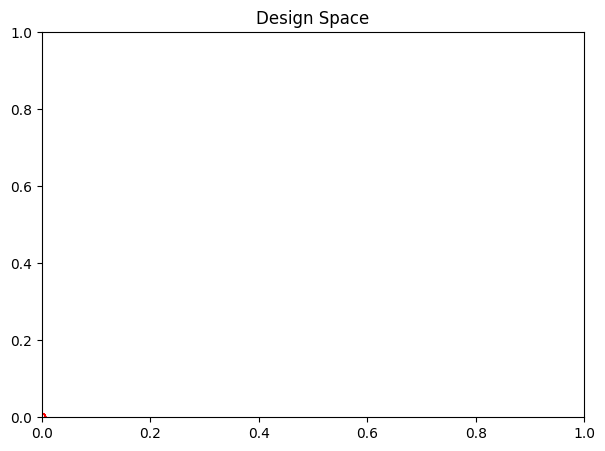

In [29]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

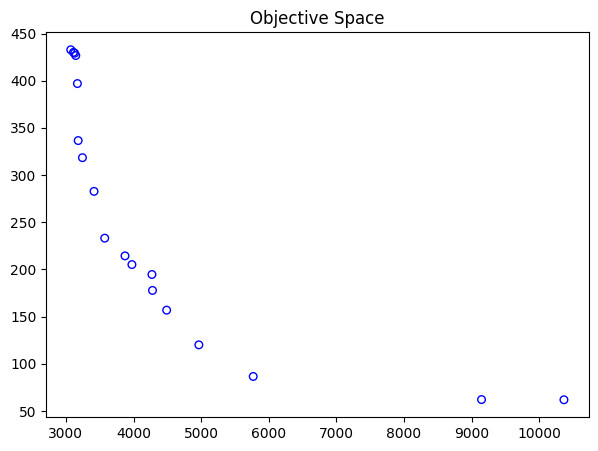

In [46]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [31]:
x_sol = X[-10]

# Debugging
variable_matrix = x_sol.reshape((len(demand_points_gdf)+1,len(line_gdf)))

cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1]

#fac_vars
print(cli_assgn_vars[1:5])
#print(np.sum(cli_assgn_vars, axis=1))
print(fac_vars)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning:

The

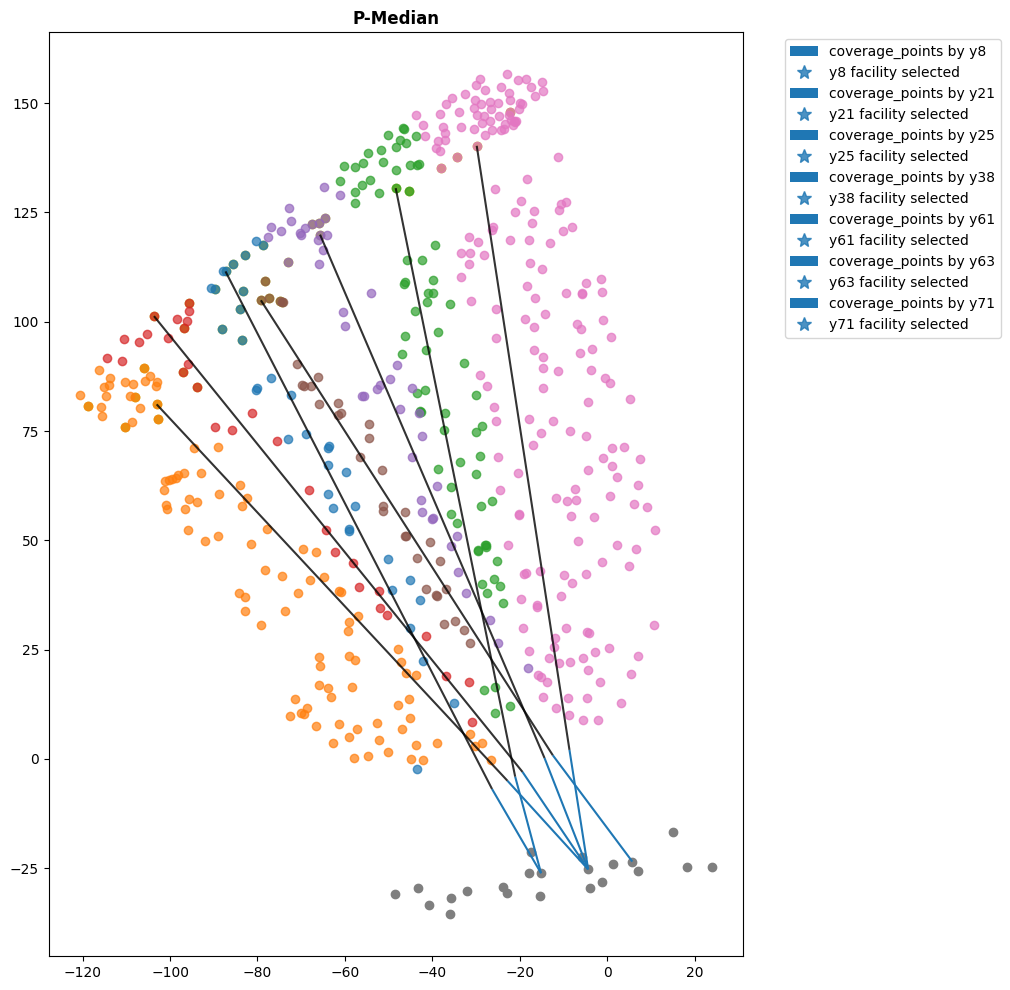

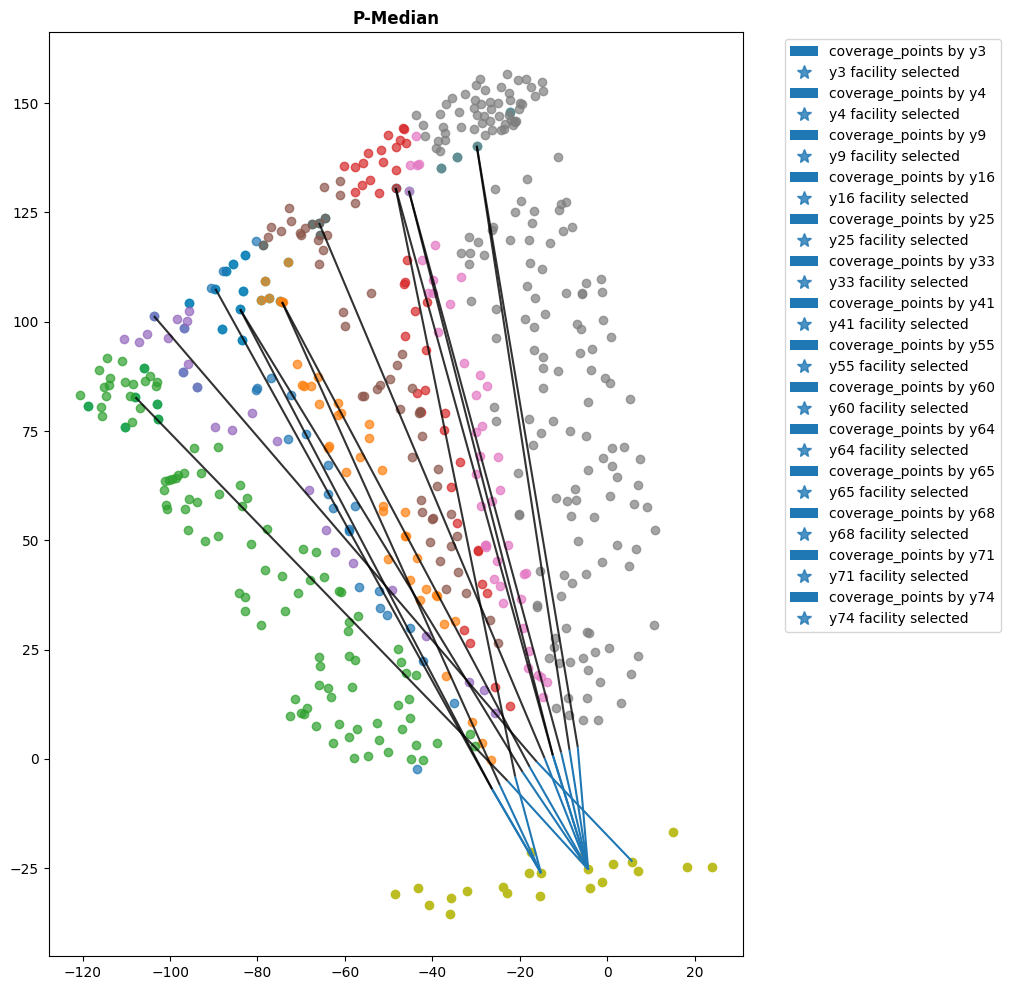

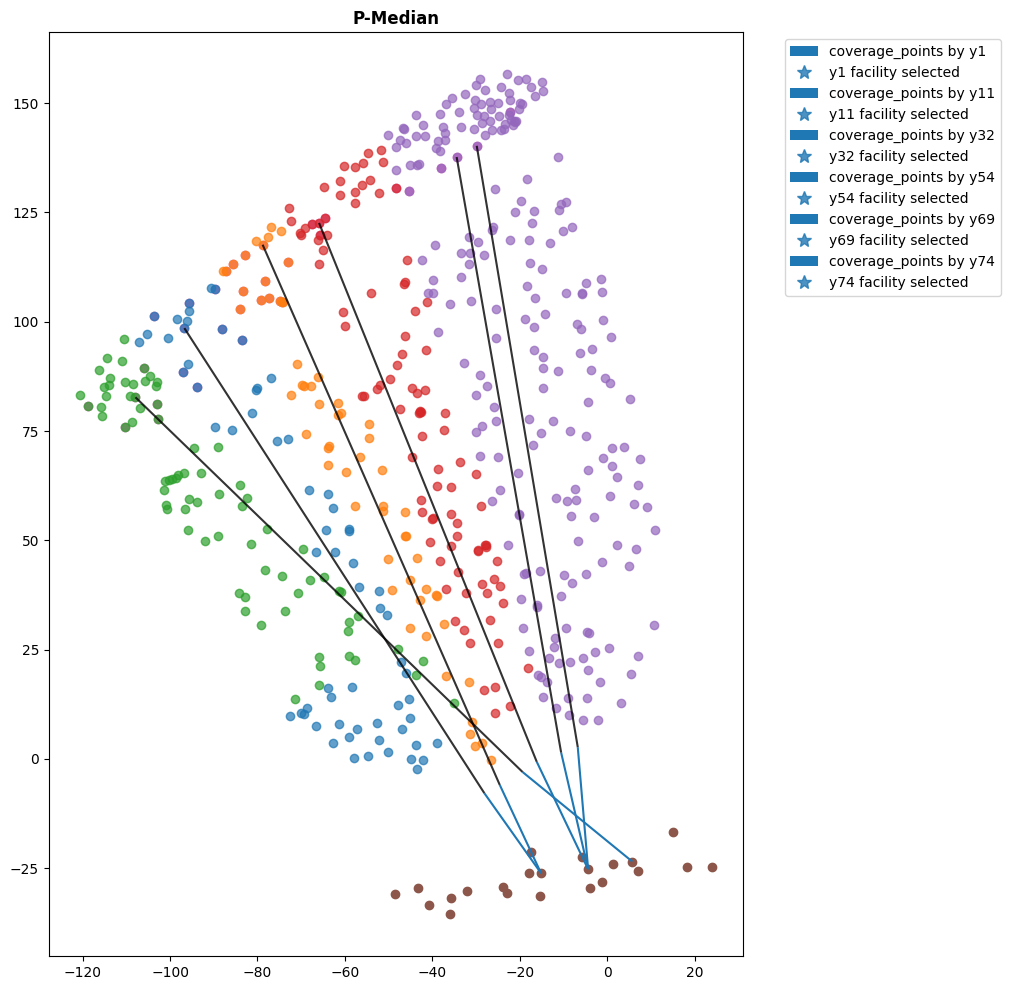

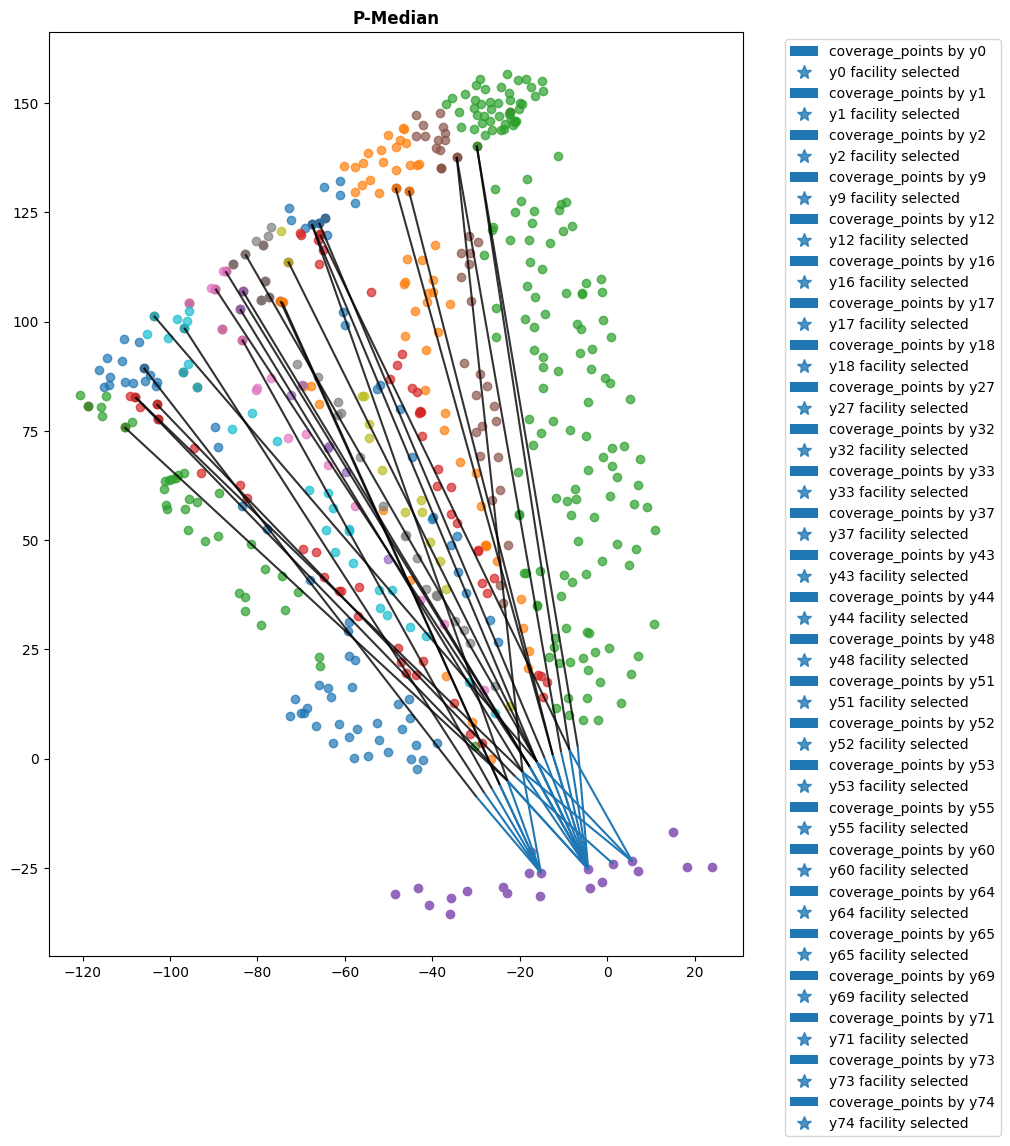

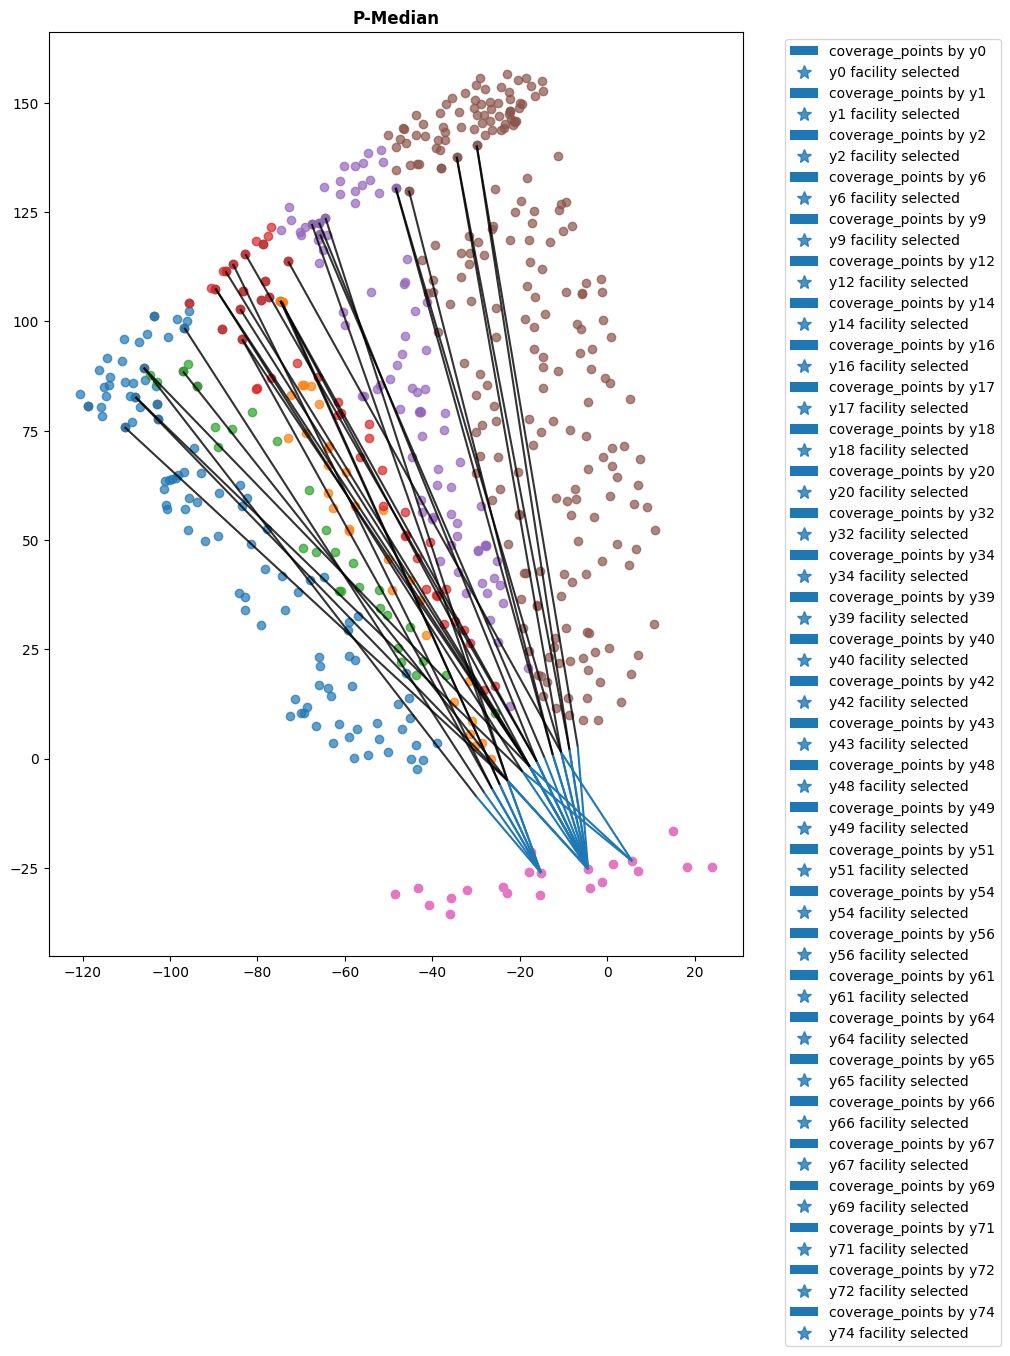

In [47]:
# Visualizations
client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]
cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:]

reload(plotting)

for x_sol in range(0,X.shape[0],4):
    plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf, target_trees_gdf, line_gdf)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

# for x_sol in range(0,X.shape[0],4):
#     plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

def plot_explain(i):
    plotting.plot_pymoo_results(X[int(i)], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=X.shape[0], step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=51.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>

In [ ]:
range(0,X.shape[0],4)

range(0, 77, 4)